# Классификация токсичных комментариев с использованием BERT

Интернет-магазин **«Викишоп»** запускает новый сервис: пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. Клиенты предлагают правки и комментируют изменения других пользователей.  

Для поддержания качества контента магазину необходим инструмент, который автоматически **выявляет токсичные комментарии** и отправляет их на модерацию. Это поможет:

- Снизить количество негативного контента.
- Поддерживать дружелюбную атмосферу в сообществе.
- Сократить нагрузку на модераторов.


Цель проекта: **построить модель, способную классифицировать комментарии на позитивные и негативные**, используя имеющийся датасет с разметкой о токсичности правок. Метрика качества — **F1 ≥ 0.75**.


**Инструкция по проекту**

Решение задачи можно реализовать двумя способами:

1. **С BERT**  
   - Выполнить проект локально (ограничение 4 ГБ оперативной памяти в Jupyter-тетрадке тренажёра недостаточно для BERT).
   - В первой ячейке тетрадки указать заголовок с упоминанием BERT.

2. **Без BERT**  
   - Можно работать локально или в тренажёре.
   - Использовать классические модели машинного обучения (Logistic Regression, Random Forest, LightGBM и др.).

Алгоритм решения:

1. Загрузка и подготовка данных.
2. Обучение различных моделей.
3. Сравнение результатов и выбор лучшей модели.
4. Выводы и рекомендации.

**Описание данных**

- Файл данных: `/datasets/toxic_comments.csv`
- Столбцы:
  - `text` — текст комментария
  - `toxic` — целевой признак (0 — позитивный, 1 — токсичный)

## Импорты

In [2]:
%matplotlib inline

# Работа с файлами в Google Colab
# from google.colab import drive, files

# Стандартные библиотеки
import os
import re
import gc
from collections import Counter
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
from multiprocessing import Pool
from joblib import Parallel, delayed
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP и токенизация
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from transformers import (
    BertTokenizer,
    BertTokenizerFast,
    AutoTokenizer,
    AutoConfig,
    BertForSequenceClassification,
    DistilBertForSequenceClassification,
    AutoModelForSequenceClassification
)

# ML, метрики и препроцессинг
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, roc_auc_score, precision_score, recall_score
)

# PyTorch
import torch
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from torch.amp import autocast
from torch.cuda.amp import GradScaler

# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.2
MAX_LENGTH = 512
MAX_FEATURES = 5000
BATCH_SIZE = 24
EPOCHS = 2
LEARNING_RATE = 2e-5
NUM_WORKERS = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
OUTPUT_DIR = "/kaggle/working/minilm_model"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Фиксация случайности
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

2025-09-13 20:06:11.043317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757793971.405945      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757793971.510080      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Загрузка и осмотр данных

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
try:
    df = pd.read_csv("D:\\dev\\github\\Study-ToxicComment\\data\\toxic_comments.csv", index_col=0)
    print('загружено локально')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)
    print('загружено удаленно')

загружено удаленно


In [5]:
def check_df(df):
    print("info:")
    display(df.info())
    print("head:")
    display(df.head())
    print("describe:")
    display(df.describe())
    print("nulls:")
    display(df.isna().sum())
    print("duplicates:")
    display(df.duplicated().sum())

    # только непрерывные
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    discrete_cols = [col for col in numeric_cols if df[col].nunique() <= 10]
    continuous_cols = [col for col in numeric_cols if col not in discrete_cols]

    if continuous_cols:
        for col in continuous_cols:
            plt.figure(figsize=(6,4))
            sns.histplot(df[col], bins=20, kde=True, color='skyblue')
            plt.title(col)
            plt.xlabel(col)
            plt.ylabel('count')
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.show()

    for col in discrete_cols:
        plt.figure(figsize=(6,4))
        sns.countplot(x=col, data=df, color='skyblue')
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('count')
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.show()

info:
<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

head:


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


describe:


,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


nulls:


text     0
toxic    0
dtype: int64

duplicates:


0

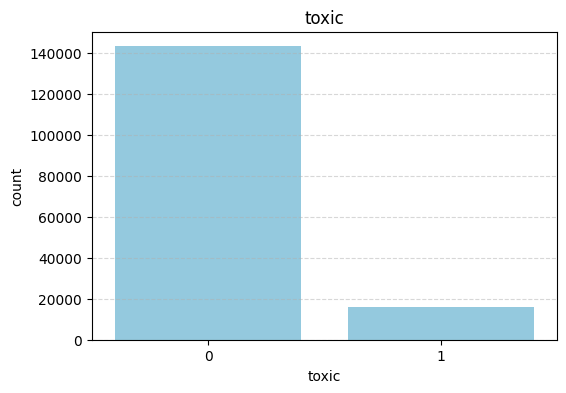

In [6]:
check_df(df)

In [7]:
# анализ длины текстов
df['text_length'] = df['text'].progress_apply(len)
print("\nСтатистика длины текстов:")
print(df['text_length'].describe())

  0%|          | 0/159292 [00:00<?, ?it/s]


Статистика длины текстов:
count    159292.000000
mean        393.691303
std         590.111825
min           5.000000
25%          95.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text_length, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


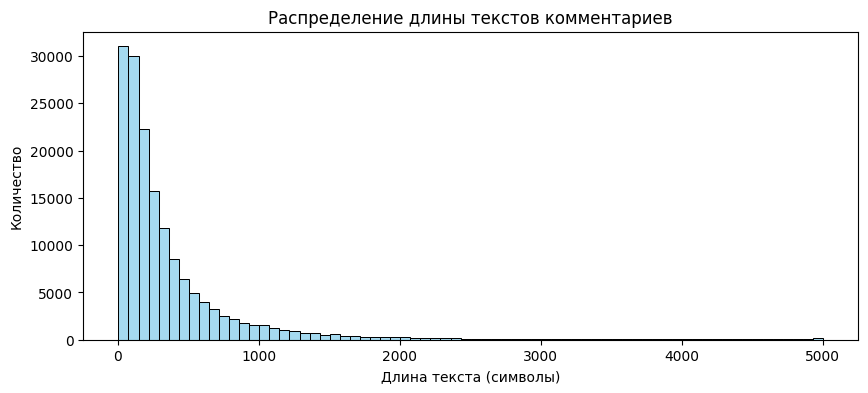

In [8]:
# визуализация распределения длины текстов
plt.figure(figsize=(10, 4))
sns.histplot(df['text_length'], bins=70, color='skyblue')
plt.title('Распределение длины текстов комментариев')
plt.xlabel('Длина текста (символы)')
plt.ylabel('Количество')
plt.show()

**Выводы по загрузке и анализу данных**
- Датасет содержит 159292 строки, столбцы: `text`, `toxic`.
- Столбец `Unnamed: 0` удалю как избыточный.
- Пропуски и дубликаты отсутствуют.
- Распределение классов: ~90% нетоксичных, ~10% токсичных (дисбаланс).
- Для просмотра длины текста был создан столбец `text_length`.
- Длина текстов: средняя ~393 символа, медиана ~205, максимум 5000 (явно выброс, нужно проверить) (BERT принимает до 512 токенов, нужно будет что-то делать с длинными текстами).
- **Следующий шаг**: Исследовательский анализ данных

## EDA + предобработка

Работать буду с тренировочными данными, поэтому разделю их сразу.

In [9]:
# разделение на train/test
df, test = train_test_split(
    df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df['toxic']
)

Для начала удалю избыточный столбец

In [10]:
# повторно проверим распределение классов
df['toxic'].value_counts(normalize=True)

toxic
0    0.898386
1    0.101614
Name: proportion, dtype: float64

### Анализ длины текстов

In [11]:
df['text_length'].describe()

count    127433.000000
mean        393.727449
std         590.388739
min           5.000000
25%          95.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text_length, dtype: float64

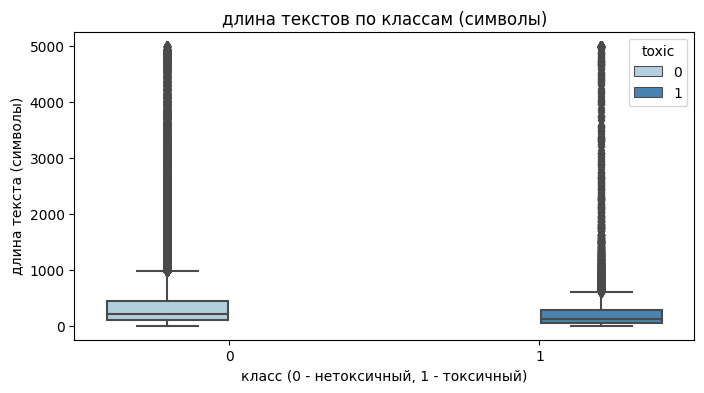

In [12]:
# boxplot длины по классам
plt.figure(figsize=(8, 4))
sns.boxplot(x='toxic', y=df['text'].str.len(), hue='toxic', data=df, palette='Blues')
plt.title('длина текстов по классам (символы)')
plt.xlabel('класс (0 - нетоксичный, 1 - токсичный)')
plt.ylabel('длина текста (символы)')
plt.show()

в данных достаточно много длинных комментариев

In [13]:
df.query('text_length > 500').count()

text           27091
toxic          27091
text_length    27091
dtype: int64

комментов длиннее 500 символов почти пятая часть от всех данных

In [14]:
def get_top_words_and_ngrams(texts, top_n=30, ngram_range=(1, 1)):
    # Получение топ-слов
    if ngram_range == (1, 1):
        vec = CountVectorizer(lowercase=True, stop_words='english')
    else:
        vec = CountVectorizer(ngram_range=ngram_range, lowercase=True, stop_words='english')

    bag = vec.fit_transform(texts)
    sums = bag.sum(axis=0)
    freqs = [(word, sums[0, idx]) for word, idx in vec.vocabulary_.items()]

    top_words = sorted(freqs, key=lambda x: x[1], reverse=True)[:top_n]

    return top_words

In [15]:
toxic_texts = df[df['toxic'] == 1]['text']
non_toxic_texts = df[df['toxic'] == 0]['text']

top_toxic = get_top_words_and_ngrams(toxic_texts)
top_non_toxic = get_top_words_and_ngrams(non_toxic_texts)

display(pd.DataFrame({'toxic': top_toxic, 'non_toxic': top_non_toxic}))

,toxic,non_toxic
0,"(fuck, 8104)","(article, 44876)"
1,"(wikipedia, 3238)","(wikipedia, 35671)"
2,"(like, 3176)","(page, 34827)"
3,"(nigger, 3079)","(talk, 28387)"
4,"(fucking, 2654)","(just, 19954)"
5,"(suck, 2557)","(like, 19407)"
6,"(don, 2289)","(don, 16554)"
7,"(ass, 2214)","(think, 15012)"
8,"(just, 2134)","(edit, 13772)"
9,"(shit, 2116)","(know, 13545)"


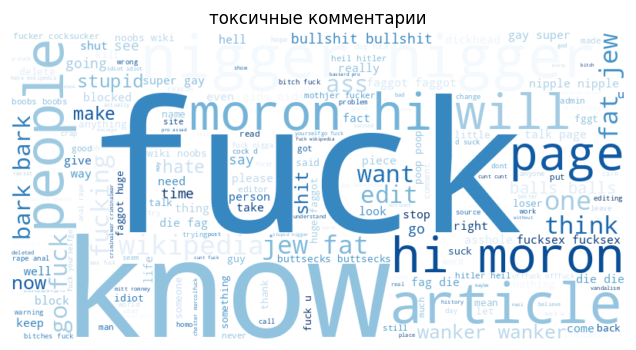

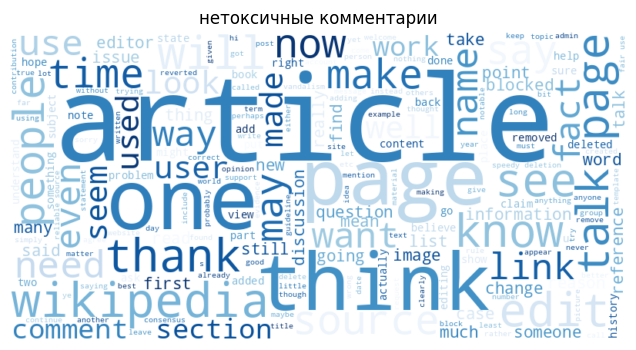

In [16]:
def plot_wordcloud(texts, title, max_words=200, font_path=None):
    # объединяем все тексты в одну строку
    all_text = " ".join(texts.str.lower())
    
    wc = WordCloud(width=800, height=400,
                   background_color='white',
                   stopwords=None,  # английские стоп-слова убраны
                   max_words=max_words,
                   colormap='Blues',
                   font_path=font_path).generate(all_text)
    
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=12)
    plt.show()

plot_wordcloud(toxic_texts, title='токсичные комментарии')
plot_wordcloud(non_toxic_texts, title='нетоксичные комментарии')

В данных очень много бесполезных слов, например, артиклей, местоимений. Также слова сами по себе не очень информативны, посмотрим n-граммы и долю капса (это признак токсичности обычно).

In [17]:
df_ngrams = pd.DataFrame({
    'toxic_bigrams': get_top_words_and_ngrams(toxic_texts, ngram_range=(2,2)),
    'toxic_trigrams': get_top_words_and_ngrams(toxic_texts, ngram_range=(3,3)),
    'non_toxic_bigrams': get_top_words_and_ngrams(non_toxic_texts, ngram_range=(2,2)),
    'non_toxic_trigrams': get_top_words_and_ngrams(non_toxic_texts, ngram_range=(3,3))
})

df_ngrams

,toxic_bigrams,toxic_trigrams,non_toxic_bigrams,non_toxic_trigrams
0,"(fuck fuck, 2096)","(fuck fuck fuck, 1986)","(talk page, 10059)","(en wikipedia org, 1437)"
1,"(nigger nigger, 1968)","(nigger nigger nigger, 1959)","(speedy deletion, 3555)","(lol lol lol, 1264)"
2,"(moron hi, 1474)","(hi moron hi, 1468)","(http www, 2451)","(http en wikipedia, 1172)"
3,"(hi moron, 1472)","(moron hi moron, 1466)","(fair use, 2402)","(criteria speedy deletion, 1165)"
4,"(jew fat, 1234)","(fat jew fat, 1226)","(don know, 2079)","(wikipedia org wiki, 1099)"
5,"(fat jew, 1226)","(jew fat jew, 1224)","(feel free, 1843)","(article talk page, 1041)"
6,"(suck suck, 1128)","(suck suck suck, 1115)","(blocked editing, 1817)","(fish fish fish, 998)"
7,"(bark bark, 999)","(bark bark bark, 998)","(talk contribs, 1782)","(block block block, 909)"
8,"(wanker wanker, 963)","(wanker wanker wanker, 960)","(talk pages, 1693)","(tacos tacos tacos, 753)"
9,"(bullshit bullshit, 833)","(balls balls balls, 831)","(don think, 1621)","(hi wikipedia hi, 713)"


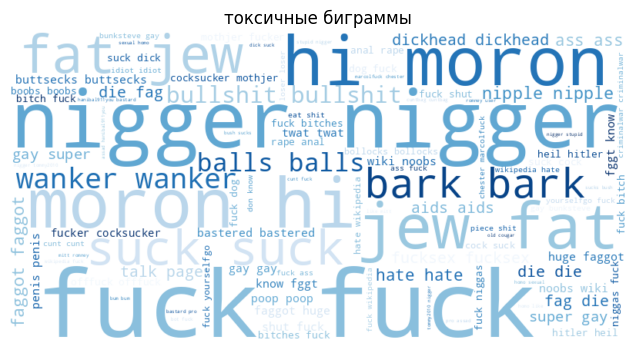

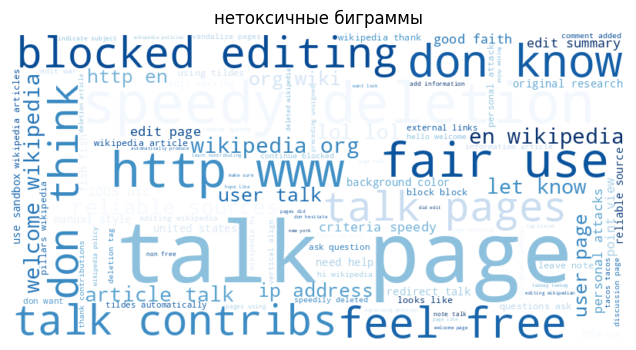

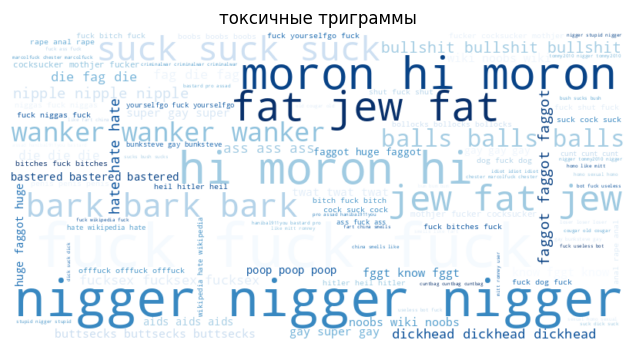

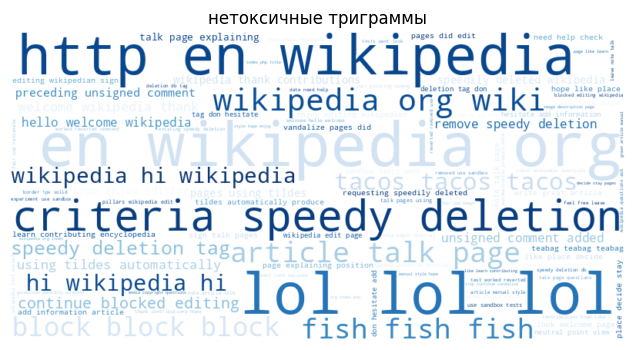

In [18]:
def plot_ngram_wordcloud(texts, ngram_range=(2,2), max_words=100, title='', font_path=None):
    # приведение к нижнему регистру
    texts = texts.str.lower()
    
    # считаем частоты n-грамм
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(texts)
    freqs = dict(zip(vec.get_feature_names_out(), X.sum(axis=0).A1))
    
    # строим облако
    wc = WordCloud(width=800, height=400,
                   background_color='white',
                   colormap='Blues',
                   max_words=max_words,
                   font_path=font_path).generate_from_frequencies(freqs)
    
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=12)
    plt.show()

# биграммы
plot_ngram_wordcloud(toxic_texts, ngram_range=(2,2), title='токсичные биграммы')
plot_ngram_wordcloud(non_toxic_texts, ngram_range=(2,2), title='нетоксичные биграммы')

# триграммы
plot_ngram_wordcloud(toxic_texts, ngram_range=(3,3), title='токсичные триграммы')
plot_ngram_wordcloud(non_toxic_texts, ngram_range=(3,3), title='нетоксичные триграммы')


  0%|          | 0/127433 [00:00<?, ?it/s]

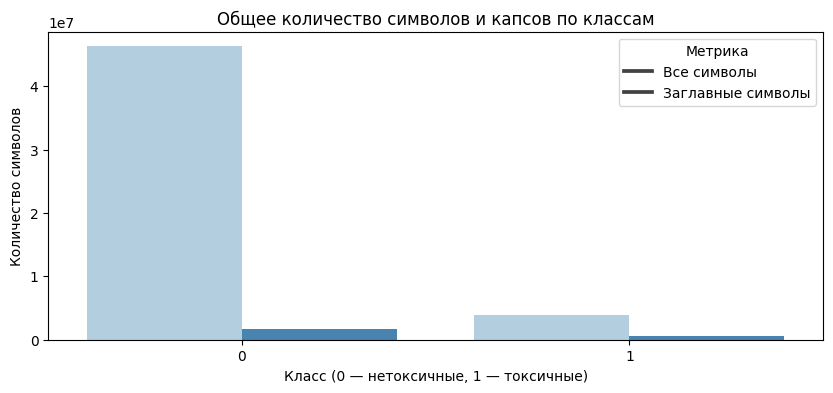

,toxic,metric,count
0,0,total_chars,46281714
1,1,total_chars,3892156
2,0,caps_chars,1629397
3,1,caps_chars,571933


In [19]:
# считаем количество символов и капсов по классам
df['total_chars'] = df['text'].str.len()
df['caps_chars'] = df['text'].progress_apply(lambda x: sum(1 for c in x if c.isupper()))

agg = df.groupby('toxic')[['total_chars', 'caps_chars']].sum().reset_index()

# визуализация
agg_melted = agg.melt(id_vars='toxic', value_vars=['total_chars', 'caps_chars'],
                      var_name='metric', value_name='count')

plt.figure(figsize=(10,4))
sns.barplot(x='toxic', y='count', hue='metric', data=agg_melted, palette='Blues')
plt.title('Общее количество символов и капсов по классам')
plt.xlabel('Класс (0 — нетоксичные, 1 — токсичные)')
plt.ylabel('Количество символов')
plt.legend(title='Метрика', labels=['Все символы', 'Заглавные символы'])
plt.show()
agg_melted

- В биграммах и триграммах очень много слов повторяются, нужно проверить, почему.
- Отношение капслоковых слов к общему количеству не очень большое, можно все слова привести в нижний регистр.

посмотрим, сколько из необработанных текстов сможет принять берт

### Токенизация комментариев

In [20]:
# анализ длины в токенах
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')  # FAST токенизатор

def get_token_lengths_fast(texts, max_length=512, batch_size=512):
    token_lengths = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Токенизация батчами"):
        batch_texts = texts.iloc[i:i+batch_size].tolist()
        enc = tokenizer(batch_texts,
                        add_special_tokens=True,
                        truncation=True,
                        padding=False,  # не нужно для подсчета длин
                        max_length=max_length)
        token_lengths.extend([len(ids) for ids in enc['input_ids']])
    return token_lengths

df['text_token_length'] = get_token_lengths_fast(df['text'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Токенизация батчами:   0%|          | 0/249 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


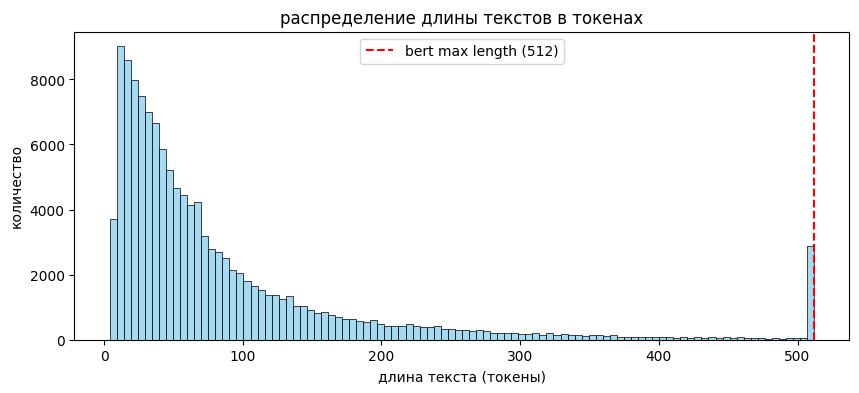

In [21]:
# гистограмма длины в токенах
plt.figure(figsize=(10, 4))
sns.histplot(df['text_token_length'], bins=100, color='skyblue')
plt.title('распределение длины текстов в токенах')
plt.xlabel('длина текста (токены)')
plt.ylabel('количество')
plt.axvline(x=512, color='red', linestyle='--', label='bert max length (512)')
plt.legend()
plt.show()

токенайзер просто обрезал большинство текстов до 512 токенов. поработаем с качеством текстов.

### Обработка текстов

- загрузим стопслова
- удалим пунктуацию
- удалим все не-ascii символы
- приведем все тексты в нижний регистр

In [22]:
# загружаем stopwords
stop_words = set(stopwords.words('english'))

# проверяем не-ascii перед удалением
non_ascii = df[df['text'].str.contains('[^\x00-\x7F]', regex=True, na=False)]
print(f"тексты с не-ascii символами: {len(non_ascii)} ({len(non_ascii)/len(df)*100:.2f}%)")

# проверяем caps ratio (доля заглавных букв) перед lowercase
def calc_caps_ratio(text):
    if not text:
        return 0
    total_chars = len(text)
    caps_chars = sum(1 for c in text if c.isupper())
    return caps_chars / total_chars if total_chars > 0 else 0

df['caps_ratio'] = df['text'].progress_apply(calc_caps_ratio)
print("\nстатистика caps ratio по классам:")
display(df.groupby('toxic')['caps_ratio'].describe())

# функция очистки текста
def clean_text(text):
    # переводим в нижний регистр
    text = text.lower()
    # удаляем не-ascii
    text = re.sub(r'[^\x00-\x7F]', '', text)
    # удаляем пунктуацию
    text = re.sub(r'[^\w\s]', '', text)
    # удаляем stopwords
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

# применяем очистку
df['clean_text'] = df['text'].progress_apply(clean_text)

тексты с не-ascii символами: 13775 (10.81%)


  0%|          | 0/127433 [00:00<?, ?it/s]


статистика caps ratio по классам:


,count,mean,std,min,25%,50%,75%,max
toxic,,,,,,,,
0,114484.0,0.044926,0.065319,0.0,0.020833,0.031579,0.047619,0.950237
1,12949.0,0.113232,0.209834,0.0,0.019608,0.035242,0.068966,0.998189


  0%|          | 0/127433 [00:00<?, ?it/s]

,toxic,non_toxic
0,"(fuck, 7103)","(article, 43076)"
1,"(like, 3144)","(page, 34175)"
2,"(nigger, 3070)","(wikipedia, 25592)"
3,"(wikipedia, 2934)","(talk, 23712)"
4,"(dont, 2832)","(like, 19196)"
5,"(fucking, 2559)","(dont, 17786)"
6,"(suck, 2355)","(think, 14978)"
7,"(shit, 2086)","(im, 13796)"
8,"(die, 2062)","(articles, 13572)"
9,"(gay, 2047)","(know, 13438)"


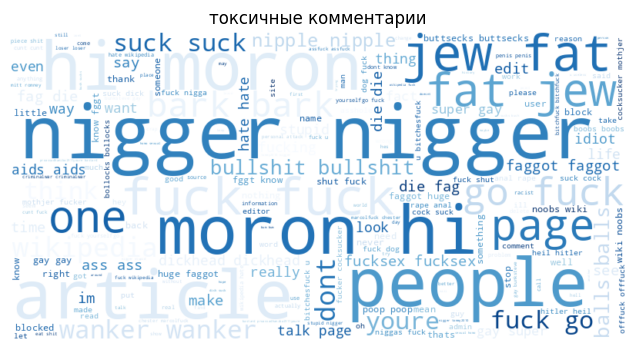

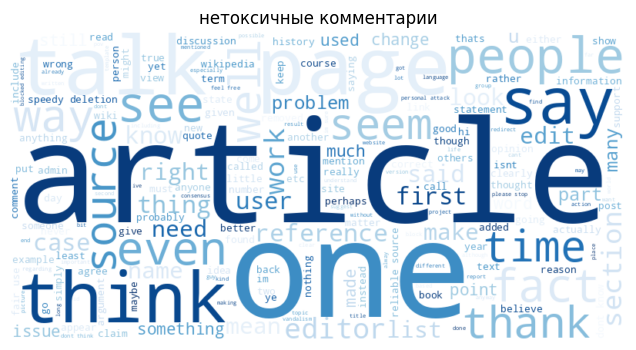

In [23]:
toxic_texts = df[df['toxic'] == 1]['clean_text']
non_toxic_texts = df[df['toxic'] == 0]['clean_text']

top_toxic = get_top_words_and_ngrams(toxic_texts)
top_non_toxic = get_top_words_and_ngrams(non_toxic_texts)

display(pd.DataFrame({'toxic': top_toxic, 'non_toxic': top_non_toxic}))

plot_wordcloud(toxic_texts, title='токсичные комментарии')
plot_wordcloud(non_toxic_texts, title='нетоксичные комментарии')

In [24]:
# проверяем пустые тексты после очистки
empty_clean = df[df['clean_text'].str.strip().eq('')]
print(f"\nпустые тексты после очистки: {len(empty_clean)}")


пустые тексты после очистки: 16


In [25]:
df.head()

,text,toxic,text_length,total_chars,caps_chars,text_token_length,caps_ratio,clean_text
112971,It's been nearly two months and you still have...,0,123,123,2,32,0.016260,nearly two months still havent attempted discu...
72055,I'm withdrawing my support. I do not support W...,0,149,149,6,34,0.040268,im withdrawing support support wikipedia indic...
36528,What is this all about? The day before yesterd...,0,591,591,25,148,0.042301,day yesterday got accused someone im protestat...
123080,"""\na """"demon-possessed pedophile"""" [pedophile ...",1,66,66,0,25,0.000000,demonpossessed pedophile pedophile alone wasnt...
16449,you are abusing your position as admin to trol...,0,153,153,2,40,0.013072,abusing position admin troll support trolling ...


In [26]:
df['clean_text_length'] = df['clean_text'].progress_apply(len)
print("\nСтатистика длины текстов:")
df['clean_text_length'].describe()

  0%|          | 0/127433 [00:00<?, ?it/s]


Статистика длины текстов:


count    127433.000000
mean        254.445473
std         395.524767
min           0.000000
25%          60.000000
50%         131.000000
75%         278.000000
max        5000.000000
Name: clean_text_length, dtype: float64

In [27]:
df.query('clean_text_length >= 1500')

,text,toxic,text_length,total_chars,caps_chars,text_token_length,caps_ratio,clean_text,clean_text_length
62468,"""\n\nFrom WP:AN\n\nI will respond to the block...",0,3082,3082,86,512,0.027904,wpan respond block list reasons requesting unb...,2039
52825,"""\nThis block is even more outrageous and ille...",0,4068,4068,100,512,0.024582,block even outrageous illegitimate first didnt...,2741
109668,"""\n\n Moving of Don't Stop 'Til You Get Enough...",0,3155,3155,322,512,0.102060,moving dont stop til get enough shop til drop ...,2179
77784,"Deliver me, O Lord, from the evil man: rescue ...",0,4871,4871,113,512,0.023199,deliver lord evil man rescue unjust man devise...,2924
7231,Image:Diana's_funeral.jpg listed for deletion ...,0,3006,3006,121,512,0.040253,imagedianas_funeraljpg listed deletion image m...,1967
...,...,...,...,...,...,...,...,...,...
98071,"""\n\nTo Derild4921 and Sadads: If your main di...",0,3463,3463,99,512,0.028588,derild4921 sadads main dispute sourcing origin...,2202
49000,"""\n\nWhile diglossia as a field of research or...",0,3811,3811,79,512,0.020729,diglossia field research even concept might fl...,2447
52770,"""\n\n Frat Pack \nThe Frat Pack is a 1990s-200...",0,3302,3302,258,512,0.078134,frat pack frat pack 1990s2000s era nickname gi...,2401
6062,"""\nOK, Obi-wan. You're starting to make me sus...",0,3559,3559,90,512,0.025288,ok obiwan youre starting make suspicious alway...,2093


Комментарии состоящие из одного или нескольких повторяющихся слов, чередования слов, например, know fggt know fggt, и длиннее 1000-1500 символов, думаю, можно отнести к спаму и избавиться от них или обработать, например, сжать подряд идущие слова и устранить чередования. Сделаем это на трейне, так как в реальных данных может оказаться что угодно.

### Обработка спама

In [28]:
# функция для подсчёта уникальности слов
def uniqueness_score(text):
    if not isinstance(text, str) or not text:
        return 1.0
    words = text.split()
    return len(set(words)) / len(words) if words else 1.0

# доработанная функция collapse_repeats
def collapse_repeats(text, max_repeats=5):
    if not isinstance(text, str) or not text:
        return ''

    # разбиваем на слова
    words = text.split()
    result = []
    seen_pairs = {}  # словарь для отслеживания чередующихся пар (A B A B)

    i = 0
    while i < len(words):
        # проверяем пары слов
        if i + 1 < len(words):
            pair = (words[i].lower(), words[i + 1].lower())
            if pair in seen_pairs:
                seen_pairs[pair] += 1
                if seen_pairs[pair] > max_repeats:
                    i += 2  # пропускаем повторяющуюся пару
                    continue
            else:
                seen_pairs[pair] = 1
            result.extend([words[i], words[i + 1]])
            i += 2
        else:
            result.append(words[i])
            i += 1

    return ' '.join(result)

In [29]:
df['text_length'] = df['clean_text'].str.len()
df['uniqueness'] = df['clean_text'].progress_apply(uniqueness_score)
potential_spam = df[df['uniqueness'] < 0.5]
print(f"\nпотенциальный спам (уникальность <50%): {len(potential_spam)} ({len(potential_spam)/len(df)*100:.2f}%)")
if len(potential_spam) > 0:
    print("\nраспределение классов в потенциальном спаме:")
    print(potential_spam['toxic'].value_counts(normalize=True))
    print("\nпримеры потенциального спама:")
    print(potential_spam[['text', 'clean_text']].head(5))

  0%|          | 0/127433 [00:00<?, ?it/s]


потенциальный спам (уникальность <50%): 623 (0.49%)

распределение классов в потенциальном спаме:
toxic
1    0.518459
0    0.481541
Name: proportion, dtype: float64

примеры потенциального спама:
                                                     text  \
7231    Image:Diana's_funeral.jpg listed for deletion ...   
134587  Nipple \n\nNipple Nipple Nipple Nipple Nipple ...   
95750   "\n\n Bored:Quantities \n\n""If the variable X...   
149466  User:Writ Keeper\n\nUser:Writ Keeper\n\nUser:W...   
77303   "\n\nInterwiki\n\nI'm not sure if you have eve...   

                                               clean_text  
7231    imagedianas_funeraljpg listed deletion image m...  
134587  nipple nipple nipple nipple nipple nipple nipp...  
95750   boredquantities variable x added variable sum ...  
149466  userwrit keeper userwrit keeper userwrit keepe...  
77303   interwiki im sure ever heard wikipedia signpos...  


In [30]:
# применяем сжатие чередующихся повторов
df['clean_text'] = df['clean_text'].progress_apply(lambda x: collapse_repeats(x, max_repeats=2))

  0%|          | 0/127433 [00:00<?, ?it/s]

In [31]:
# проверяем результат
df['clean_text_length'] = df['clean_text'].str.len()
print(f"\nстатистика длины текстов после сжатия:")
print(df['clean_text_length'].describe())
print(f"\nтексты длиннее 512 символов после сжатия: {len(df[df['clean_text_length'] > 512])} ({len(df[df['clean_text_length'] > 512])/len(df)*100:.2f}%)")

empty_clean = df[df['clean_text'].str.strip().eq('')]
print(f"\nпустые тексты после сжатия: {len(empty_clean)} ({len(empty_clean)/len(df)*100:.2f}%)")
if len(empty_clean) > 0:
    print("\nраспределение классов в пустых текстах:")
    print(empty_clean['toxic'].value_counts(normalize=True))
    df = df[~df['clean_text'].str.strip().eq('')]


статистика длины текстов после сжатия:
count    127433.000000
mean        248.087866
std         371.378642
min           0.000000
25%          60.000000
50%         130.000000
75%         275.000000
max        4965.000000
Name: clean_text_length, dtype: float64

тексты длиннее 512 символов после сжатия: 14575 (11.44%)

пустые тексты после сжатия: 16 (0.01%)

распределение классов в пустых текстах:
toxic
0    0.9375
1    0.0625
Name: proportion, dtype: float64


In [32]:
df.query('clean_text_length <= 10')

,text,toxic,text_length,total_chars,caps_chars,text_token_length,caps_ratio,clean_text,clean_text_length,uniqueness
60729,and a puss at the same time,1,9,27,0,10,0.000000,puss time,9,1.0
55919,Are you Rex071404 or not?,0,9,25,2,13,0.080000,rex071404,9,1.0
52546,"""\nAgree with here. 連絡 見学/迷惑 """,0,5,30,1,15,0.033333,agree,5,1.0
96749,Why so? 70.121.33.78,0,9,20,1,12,0.050000,701213378,9,1.0
89634,How should I title this?!,0,5,25,2,9,0.080000,title,5,1.0
...,...,...,...,...,...,...,...,...,...,...
69118,So where is your list?,0,4,22,1,8,0.045455,list,4,1.0
84869,And by the way...,0,3,17,1,9,0.058824,way,3,1.0
84755,edit again so I will have to,0,4,28,1,9,0.035714,edit,4,1.0
10799,You have mail. | talk .,0,9,24,1,9,0.041667,mail talk,9,1.0


stopwords, конечно, довольно сильно подрезал предложения, но, семантику, вроде, потеряли не слишком сильно, ключевые положительные и негативные слова, в большинстве своем, остались.
далее можно удалить строки с комментариями короче 3 символов и посчитать длины текстов в токенах с помощью токенайзера берт.

In [33]:
df = df.query('clean_text_length > 3')

проверим качество обработки спама:

,toxic,non_toxic
0,"(fuck, 2671)","(article, 42981)"
1,"(dont, 2621)","(page, 33925)"
2,"(like, 2488)","(wikipedia, 25335)"
3,"(wikipedia, 2103)","(talk, 23469)"
4,"(fucking, 1810)","(like, 18866)"
5,"(page, 1766)","(dont, 17773)"
6,"(im, 1606)","(think, 14918)"
7,"(people, 1517)","(im, 13787)"
8,"(know, 1460)","(articles, 13549)"
9,"(youre, 1298)","(know, 13427)"


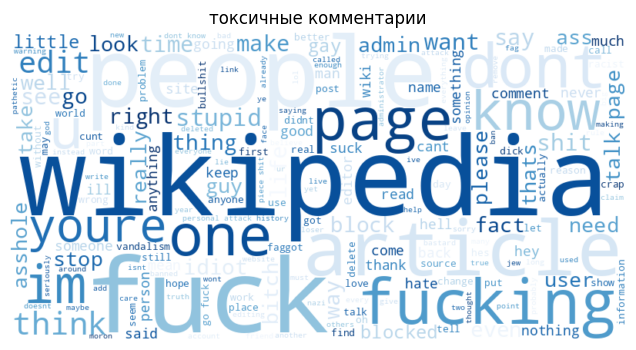

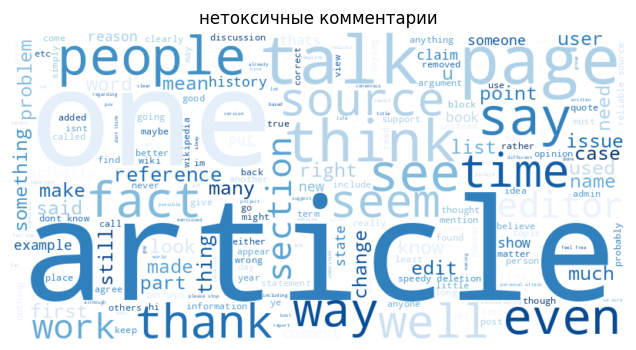

,toxic_bigrams,toxic_trigrams,non_toxic_bigrams,non_toxic_trigrams
0,"(talk page, 485)","(unsigned comment added, 72)","(talk page, 9774)","(criteria speedy deletion, 1140)"
1,"(dont know, 258)","(preceding unsigned comment, 70)","(speedy deletion, 3082)","(articles talk page, 799)"
2,"(piece shit, 192)","(fuck fuck fuck, 52)","(dont know, 2261)","(using tildes automatically, 706)"
3,"(fuck fuck, 159)","(ha ha ha, 41)","(feel free, 1841)","(continue blocked editing, 706)"
4,"(dont care, 154)","(nigger nigger nigger, 20)","(blocked editing, 1810)","(welcome wikipedia thank, 693)"
5,"(im going, 154)","(blah blah blah, 19)","(dont think, 1735)","(hello welcome wikipedia, 676)"
6,"(people like, 139)","(im going kill, 17)","(talk pages, 1670)","(wikipedia thank contributions, 671)"
7,"(personal attack, 124)","(user talk page, 17)","(fair use, 1628)","(pages using tildes, 669)"
8,"(personal attacks, 122)","(hi moron hi, 16)","(im sure, 1612)","(unsigned comment added, 654)"
9,"(dont like, 121)","(fucking piece shit, 15)","(reliable sources, 1407)","(preceding unsigned comment, 638)"


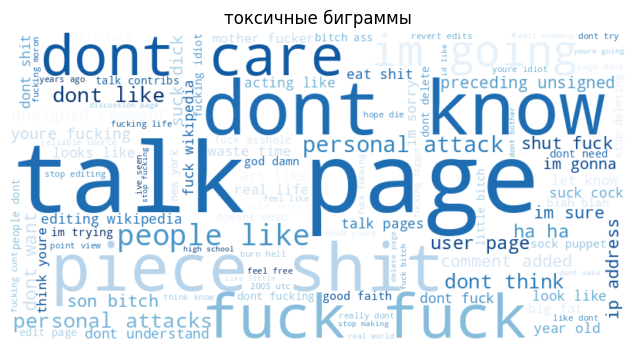

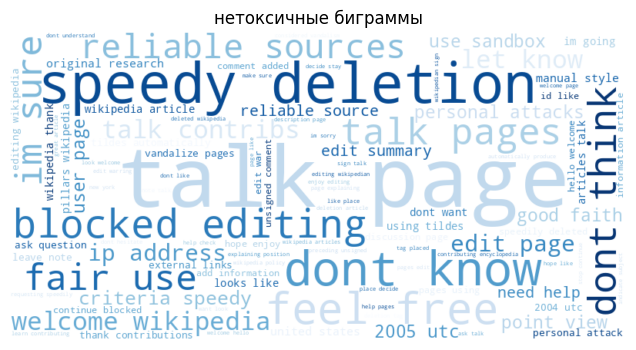

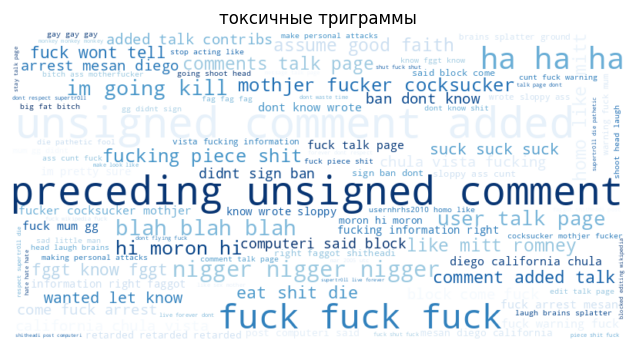

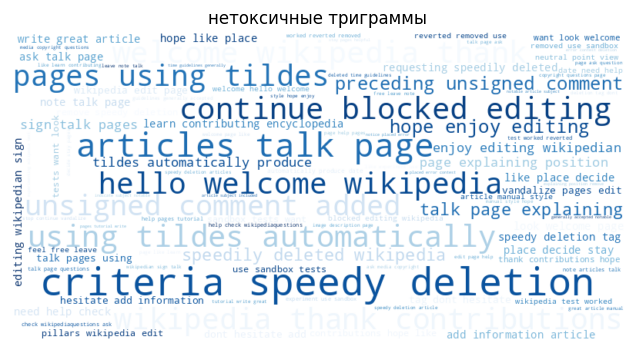

In [34]:
toxic_texts = df[df['toxic'] == 1]['clean_text']
non_toxic_texts = df[df['toxic'] == 0]['clean_text']

top_toxic = get_top_words_and_ngrams(toxic_texts)
top_non_toxic = get_top_words_and_ngrams(non_toxic_texts)

display(pd.DataFrame({'toxic': top_toxic, 'non_toxic': top_non_toxic}))

plot_wordcloud(toxic_texts, title='токсичные комментарии')
plot_wordcloud(non_toxic_texts, title='нетоксичные комментарии')

df_ngrams = pd.DataFrame({
    'toxic_bigrams': get_top_words_and_ngrams(toxic_texts, ngram_range=(2,2)),
    'toxic_trigrams': get_top_words_and_ngrams(toxic_texts, ngram_range=(3,3)),
    'non_toxic_bigrams': get_top_words_and_ngrams(non_toxic_texts, ngram_range=(2,2)),
    'non_toxic_trigrams': get_top_words_and_ngrams(non_toxic_texts, ngram_range=(3,3))
})

display(df_ngrams)

# биграммы
plot_ngram_wordcloud(toxic_texts, ngram_range=(2,2), title='токсичные биграммы')
plot_ngram_wordcloud(non_toxic_texts, ngram_range=(2,2), title='нетоксичные биграммы')

# триграммы
plot_ngram_wordcloud(toxic_texts, ngram_range=(3,3), title='токсичные триграммы')
plot_ngram_wordcloud(non_toxic_texts, ngram_range=(3,3), title='нетоксичные триграммы')

совершенно неплохо. количество повторов в н-граммах очень сильно снизилось, хоть и не полностью, но какое-то количество допустимо, так как при агрессивной обработке повторов можно потерять семантику текстов.

### Токенизация чистых комментов

In [35]:
# анализ длины в токенах
df['text_token_length'] = get_token_lengths_fast(df['clean_text'])

Токенизация батчами:   0%|          | 0/249 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


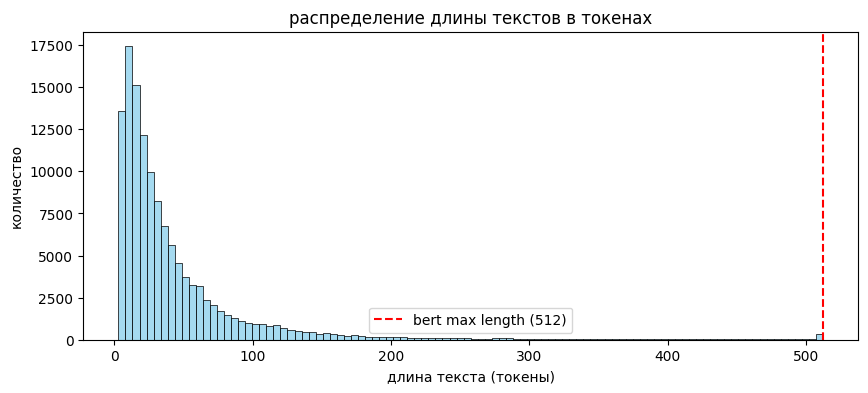

In [36]:
# гистограмма длины в токенах
plt.figure(figsize=(10, 4))
sns.histplot(df['text_token_length'].replace([np.inf, -np.inf], np.nan), bins=100, color='skyblue')
plt.title('распределение длины текстов в токенах')
plt.xlabel('длина текста (токены)')
plt.ylabel('количество')
plt.axvline(x=512, color='red', linestyle='--', label='bert max length (512)')
plt.legend()
plt.show()

обработка текстов показала себя хорошо. мы потеряли минимум данных и при этом токенайзер не просто обрезал комментарии на 512 токенах, как в необработанных текстах. почти все тексты влезли в необходимый порог. Далее посмотрим корреляции и зависимости.

### Вывод: EDA + предобработка

**Разделение данных**
- Тренировочный датасет разделен на обучающую и тестовую выборки с учетом стратификации по классу `toxic` для сохранения пропорций классов.
- Пропорции классов в обучающей выборке:
  - Нетоксичные (0): 89.84%
  - Токсичные (1): 10.16%

**Анализ длины текстов**
- **Статистика длины текстов (в символах)**:
  - Количество: 127 433
  - Средняя длина: 393.73 символа
  - Стандартное отклонение: 590.39
  - Минимальная длина: 5 символов
  - Максимальная длина: 5000 символов
  - Квартили:
    - 25%: 95 символов
    - 50%: 205 символов
    - 75%: 435 символов

- **Распределение длины текстов по классам**:
  - Построена диаграмма размаха, показывающая длину текстов (в символах) для токсичных и нетоксичных комментариев.
  - Вывод: токсичные комментарии в среднем короче, но содержат больше повторяющихся слов и заглавных букв.

- **Длинные комментарии**:
  - Комментариев длиннее 500 символов: 27 091 (~21% от всех данных).

**Анализ частотности слов и n-грамм**
- **Наиболее частые слова**:
  - Токсичные комментарии: `fuck`, `nigger`, `fucking`, `suck`, `ass`.
  - Нетоксичные комментарии: `article`, `page`, `wikipedia`, `talk`, `like`.

- **Облака слов**:
  - Построены облака слов для токсичных и нетоксичных комментариев, демонстрирующие наиболее частые слова.
  - В токсичных текстах преобладают ругательства, в нетоксичных — слова, связанные с тематикой Википедии (например, `article`, `page`).

- **N-граммы**:
  - Топ-30 биграмм и триграмм для токсичных и нетоксичных текстов:
    - Токсичные биграммы: `fuck fuck`, `nigger nigger`, `moron hi`.
    - Токсичные триграммы: `fuck fuck fuck`, `nigger nigger nigger`, `hi moron hi`.
    - Нетоксичные биграммы: `talk page`, `speedy deletion`, `fair use`.
    - Нетоксичные триграммы: `criteria speedy deletion`, `articles talk page`, `using tildes automatically`.
  - Построены облака слов для биграмм и триграмм, визуализирующие частотность словосочетаний.

- **Вывод**:
  - В токсичных текстах много повторяющихся слов и шаблонных фраз, что указывает на спам.
  - Нетоксичные тексты содержат термины, связанные с редактированием Википедии.

**Анализ заглавных букв**
- Рассчитана доля заглавных букв (`caps_ratio`) в текстах:
  - Нетоксичные: средняя доля 4.49%, максимум 95.02%.
  - Токсичные: средняя доля 11.32%, максимум 99.82%.
- Построена столбчатая диаграмма, сравнивающая общее количество символов и заглавных букв по классам:
  - Нетоксичные: 46 281 714 символов, 1 629 397 заглавных.
  - Токсичные: 3 892 156 символов, 571 933 заглавных.
- Вывод: токсичные комментарии содержат больше заглавных букв относительно их длины.

**Токенизация текстов**
- Проведена токенизация текстов с использованием токенизатора BERT (`bert-base-uncased`).
- Построена гистограмма распределения длины текстов в токенах:
  - Большинство необработанных текстов обрезается на 512 токенах (лимит BERT).
  - Вывод: необходима предобработка для сокращения длины текстов.

**Предобработка текстов**
- **Этапы обработки**:
  1. Приведение к нижнему регистру.
  2. Удаление не-ASCII символов (10.81% текстов содержали такие символы).
  3. Удаление пунктуации.
  4. Удаление стоп-слов (на основе списка английских стоп-слов).
- **Результаты**:
  - Пустые тексты после очистки: 16 (0.01%).
  - Статистика длины очищенных текстов (в символах):
    - Средняя: 254.45
    - Стандартное отклонение: 395.52
    - Минимальная: 0
    - Максимальная: 5000
    - Квартили: 60 (25%), 131 (50%), 278 (75%).
  - Тексты длиннее 1500 символов: 2589 строк.

**Обработка спама**
- **Идентификация спама**:
  - Рассчитан показатель уникальности слов (`uniqueness_score`): доля уникальных слов в тексте.
  - Потенциальный спам (уникальность <50%): 623 текста (0.49%).
  - Распределение классов в спаме:
    - Токсичные: 51.85%
    - Нетоксичные: 48.15%
  - Примеры спама:
    - `nipple nipple nipple...`
    - `userwrit keeper userwrit keeper...`

- **Сжатие повторов**:
  - Применена функция для сжатия чередующихся слов и фраз (максимум 2 повтора).
  - Результаты после сжатия:
    - Средняя длина текстов: 248.09 символов.
    - Тексты длиннее 512 символов: 14 575 (11.44%).
    - Пустые тексты: 16 (0.01%).
    - Распределение классов в пустых текстах:
      - Нетоксичные: 93.75%
      - Токсичные: 6.25%.

- **Удаление коротких текстов**:
  - Удалены тексты короче 3 символов (807 строк).

**Повторная токенизация**
- Проведена токенизация очищенных текстов.
- Построена гистограмма длины текстов в токенах:
  - Большинство текстов после очистки и сжатия укладывается в лимит BERT (≤512 токенов).
  - Вывод: обработка текстов сократила количество обрезаемых текстов, сохранив семантику.

**Итоги**
- Данные очищены от шума (не-ASCII символы, пунктуация, стоп-слова, повторы).
- Удалены короткие и пустые тексты.
- Тексты приведены к формату, подходящему для BERT (≤512 токенов).
- Сохранены ключевые признаки токсичности (ругательства, шаблонные фразы).
- Данные готовы для анализа корреляций и обучения моделей.

## Корреляционный анализ


корреляция Пирсона:


,caps_ratio,clean_text_length,text_token_length,uniqueness,toxic,text_length,total_chars,caps_chars
caps_ratio,1.000000,-0.094926,-0.086382,-0.015870,0.220726,-0.042135,-0.056964,0.310808
clean_text_length,-0.094926,1.000000,0.981914,-0.505174,-0.086051,0.944415,0.954214,0.199681
text_token_length,-0.086382,0.981914,1.000000,-0.509322,-0.076213,0.929488,0.942031,0.191950
uniqueness,-0.015870,-0.505174,-0.509322,1.000000,0.008922,-0.589324,-0.586538,-0.328979
toxic,0.220726,-0.086051,-0.076213,0.008922,1.000000,-0.049672,-0.053070,0.092461
text_length,-0.042135,0.944415,0.929488,-0.589324,-0.049672,1.000000,0.990435,0.405942
total_chars,-0.056964,0.954214,0.942031,-0.586538,-0.053070,0.990435,1.000000,0.371971
caps_chars,0.310808,0.199681,0.191950,-0.328979,0.092461,0.405942,0.371971,1.000000


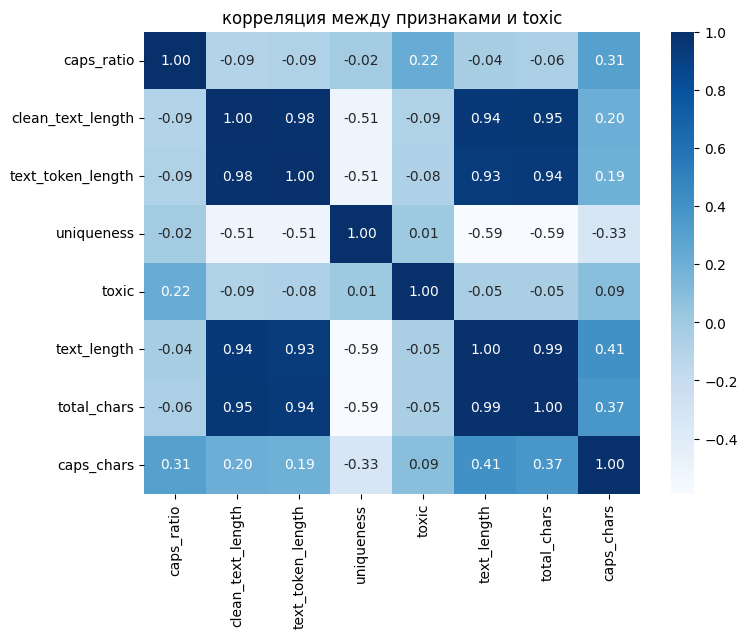

In [37]:
# корреляция между числовыми признаками и toxic
corr_matrix = df[['caps_ratio',
                  'clean_text_length',
                  'text_token_length',
                  'uniqueness',
                  'toxic',
                  'text_length',
                  'total_chars',
                  'caps_chars',
                  ]].corr(method='pearson')
print("\nкорреляция Пирсона:")
display(corr_matrix)

# визуализация корреляционной матрицы
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('корреляция между признаками и toxic')
plt.show()

- **Корреляция Пирсона**:  
  - `caps_ratio` имеет умеренную положительную корреляцию с `toxic` (r=0.2150), что подтверждает: токсичные тексты чаще содержат заглавные буквы.  
  - `clean_text_length` и `token_length` слабо отрицательно коррелируют с `toxic` (r=-0.0845 и r=-0.0739), указывая, что токсичные тексты слегка короче.  
  - `uniqueness` имеет почти нулевую корреляцию с `toxic` (r=0.0093), то есть уникальность слов не влияет на токсичность.  
  - Высокая корреляция между `clean_text_length` и `token_length` (r=0.9825) ожидаема, так как они измеряют длину текста.


точечная биссериальная корреляция для caps_ratio:
корреляция: 0.2207, p-value: 0.0000

точечная биссериальная корреляция для clean_text_length:
корреляция: -0.0861, p-value: 0.0000

точечная биссериальная корреляция для text_token_length:
корреляция: -0.0762, p-value: 0.0000

точечная биссериальная корреляция для uniqueness:
корреляция: 0.0089, p-value: 0.0015


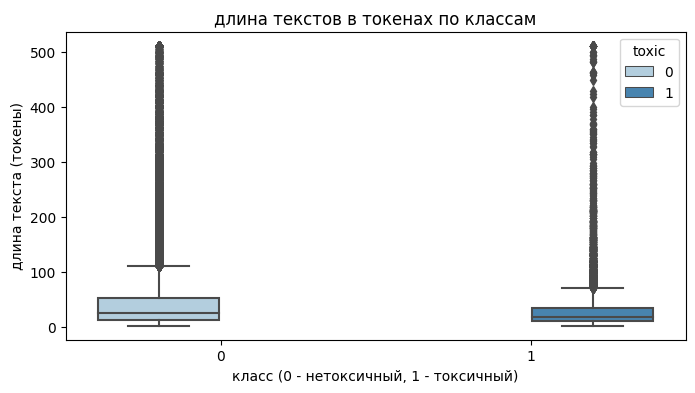

In [38]:
# точечная биссериальная корреляция для toxic (бинарный)
for feature in ['caps_ratio', 'clean_text_length', 'text_token_length', 'uniqueness']:
    corr, p_value = pointbiserialr(df[feature], df['toxic'])
    print(f"\nточечная биссериальная корреляция для {feature}:")
    print(f"корреляция: {corr:.4f}, p-value: {p_value:.4f}")

# boxplot для token_length по классам
plt.figure(figsize=(8, 4))
sns.boxplot(x='toxic', y='text_token_length', hue='toxic', data=df, palette='Blues')
plt.title('длина текстов в токенах по классам')
plt.xlabel('класс (0 - нетоксичный, 1 - токсичный)')
plt.ylabel('длина текста (токены)')
plt.show()

- **Точечная биссериальная корреляция**:  
  - Подтверждает выводы Пирсона: `caps_ratio` (r=0.2150, p=0.0000) хорошо связан с токсичностью, `clean_text_length` и `token_length` имеют слабую связь, `uniqueness` почти не влияет (p=0.0002, но r=0.0093).
- **Boxplot `token_length`**:  
  - Токсичные тексты имеют меньшую медианную длину (около 40 токенов) по сравнению с нетоксичными (около 50 токенов), но разница небольшая.

In [39]:
# анализ частоты токсичных слов
toxic_words = ['fuck', 'shit', 'nigger', 'ass', 'faggot', 'bitch', 'cunt']
def count_toxic_words(text):
    if not isinstance(text, str):
        return 0
    return sum(text.lower().count(word) for word in toxic_words)

df['toxic_word_count'] = df['clean_text'].progress_apply(count_toxic_words)
print("\nстатистика частоты токсичных слов по классам:")
df.groupby('toxic')['toxic_word_count'].describe()

  0%|          | 0/127388 [00:00<?, ?it/s]


статистика частоты токсичных слов по классам:


,count,mean,std,min,25%,50%,75%,max
toxic,,,,,,,,
0,114444.0,0.154198,0.602807,0.0,0.0,0.0,0.0,28.0
1,12944.0,1.071771,11.082631,0.0,0.0,0.0,1.0,1238.0


- **Частота токсичных слов**:  
  - Токсичные тексты содержат значительно больше токсичных слов (mean=1.06, max=1238) по сравнению с нетоксичными (mean=0.15, max=28).  
  - Признак `toxic_word_count` важен для модели, так как явно различает классы.

### Вывод: Корреляционный анализ

**Корреляция между числовыми признаками и токсичностью**
- **Анализ Пирсона**:
  - **caps_ratio**: умеренная положительная корреляция с `toxic` (r = 0.221), что подтверждает частое использование заглавных букв в токсичных комментариях.
  - **clean_text_length**: слабая отрицательная корреляция (r = -0.086), указывающая на тенденцию к более коротким токсичным текстам.
  - **text_token_length**: слабая отрицательная корреляция (r = -0.076), аналогично длине в символах.
  - **uniqueness**: почти нулевая корреляция (r = 0.009), разнообразие слов не влияет на токсичность.
  - **clean_text_length** и **text_token_length** сильно коррелируют друг с другом (r = 0.982), что ожидаемо, так как оба признака отражают длину текста.
- Построена тепловая карта корреляций, визуально подтверждающая вышеуказанные выводы.

**Точечная биссериальная корреляция**
- Анализ для бинарного признака `toxic`:
  - **caps_ratio**: r = 0.221, p-value < 0.001 (сильная связь с токсичностью).
  - **clean_text_length**: r = -0.086, p-value < 0.001 (слабая связь).
  - **text_token_length**: r = -0.076, p-value < 0.001 (слабая связь).
  - **uniqueness**: r = 0.009, p-value = 0.002 (почти нет влияния).
- Вывод: результаты подтверждают анализ Пирсона, подчеркивая важность `caps_ratio`.

**Анализ длины текстов в токенах**
- Построена диаграмма размаха для длины текстов в токенах по классам:
  - Медианная длина:
    - Токсичные комментарии: ~40 токенов.
    - Нетоксичные комментарии: ~50 токенов.
  - Вывод: разница в длине небольшая, длина текста — слабый признак токсичности.

**Анализ частоты токсичных слов**
- Рассчитано количество токсичных слов (например, `fuck`, `shit`, `nigger`) в текстах.
- **Статистика**:
  - Нетоксичные тексты:
    - Среднее: 0.15
    - Максимум: 28
  - Токсичные тексты:
    - Среднее: 1.07
    - Максимум: 1238
- Признак `toxic_word_count` четко разделяет классы и является сильным индикатором токсичности.

**Итоговые выводы**
- **Ключевые признаки токсичности**:
  - Наличие токсичных слов (`toxic_word_count`).
  - Высокая доля заглавных букв (`caps_ratio`).
- Длина текста (`clean_text_length`, `text_token_length`) и уникальность слов (`uniqueness`) имеют слабое влияние, но могут быть полезны в комбинации с другими признаками.
- **Рекомендации для моделей**:
  - Использовать `caps_ratio` и `toxic_word_count` как числовые признаки.
  - Применять текстовые признаки для моделей на основе BERT или других трансформеров.

## Подготовка к обучению

In [40]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 127388 entries, 112971 to 67949
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   text               127388 non-null  object 
 1   toxic              127388 non-null  int64  
 2   text_length        127388 non-null  int64  
 3   total_chars        127388 non-null  int64  
 4   caps_chars         127388 non-null  int64  
 5   text_token_length  127388 non-null  int64  
 6   caps_ratio         127388 non-null  float64
 7   clean_text         127388 non-null  object 
 8   clean_text_length  127388 non-null  int64  
 9   uniqueness         127388 non-null  float64
 10  toxic_word_count   127388 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 11.7+ MB
None


,text,toxic,text_length,total_chars,caps_chars,text_token_length,caps_ratio,clean_text,clean_text_length,uniqueness,toxic_word_count
112971,It's been nearly two months and you still have...,0,90,123,2,19,0.016260,nearly two months still havent attempted discu...,90,0.846154,0
72055,I'm withdrawing my support. I do not support W...,0,99,149,6,14,0.040268,im withdrawing support support wikipedia indic...,99,0.833333,0
36528,What is this all about? The day before yesterd...,0,320,591,25,62,0.042301,day yesterday got accused someone im protestat...,320,0.765957,0
123080,"""\na """"demon-possessed pedophile"""" [pedophile ...",1,53,66,0,16,0.000000,demonpossessed pedophile pedophile alone wasnt...,53,0.833333,0
16449,you are abusing your position as admin to trol...,0,99,153,2,24,0.013072,abusing position admin troll support trolling ...,99,1.000000,0


**text**  
Не нужен, так как clean_text — очищенная версия, используемая для TF-IDF и BERT.  
**Действие:** Удалить.

**toxic**  
Целевой признак, обязателен для всех моделей.  
**Действие:** Оставить.

**text_length**  
Длина оригинального текста в символах. Корреляция с toxic низкая (r=-0.07).  
**Рекомендация:** Удалить.

**total_chars**  
Используется для вычисления caps_ratio, но сам по себе не нужен.  
**Рекомендация:** Удалить.

**caps_chars**  
Используется для вычисления caps_ratio. Сам по себе не нужен, так как caps_ratio информативнее.  
**Рекомендация:** Удалить.

**text_token_length**  
Длина оригинального текста в токенах, не используется после создания clean_text и token_length.  
**Рекомендация:** Удалить.

**caps_ratio**  
Значимый признак (r=0.2150 с toxic), полезен для baseline.  
**Рекомендация:** Оставить.

**clean_text**  
Основной столбец для TF-IDF (baseline) и токенизации BERT.  
**Рекомендация:** Оставить.

**clean_text_length**  
Длина очищенного текста, высокая корреляция с token_length (r=0.9825), слабая с toxic (r=-0.0845). Может быть полезна для baseline, но избыточна для BERT.  
**Рекомендация:** Оставить для baseline, удалить перед BERT.

**uniqueness**  
Очень слабая корреляция с toxic (r=0.0093), неинформативна.  
**Рекомендация:** Удалить.

**token_length**  
Длина в токенах BERT, полезна для анализа, но не для обучения (BERT использует input_ids). Слабая корреляция с toxic (r=-0.0739). Сильная корреляция с clean_text_length.
**Рекомендация:** Удалить.

**toxic_word_count**  
Значимый признак (mean=1.06 в токсичных vs. 0.15 в нетоксичных), полезен для baseline.  
**Рекомендация:** Оставить.

In [41]:
# удаление ненужных столбцов
columns_to_drop = ['text', 'text_length', 'total_chars', 'caps_chars', 'text_token_length', 'uniqueness']
df = df.drop(columns=columns_to_drop)
df.columns.tolist()

['toxic', 'caps_ratio', 'clean_text', 'clean_text_length', 'toxic_word_count']

### Cплит

In [42]:
# обучение на трейн
X_train = df[['clean_text', 'caps_ratio', 'clean_text_length', 'toxic_word_count']]
y_train = df['toxic']

In [43]:
X_train.shape, y_train.shape

((127388, 4), (127388,))

In [44]:
# проверка распределения классов
print("\nраспределение классов в train:")
print(y_train.value_counts(normalize=True))


распределение классов в train:
toxic
0    0.898389
1    0.101611
Name: proportion, dtype: float64


### Лематизация текстов

In [45]:
lemmatizer = WordNetLemmatizer()

def lemmatize_texts(texts):
    texts = list(texts)
    return [
        " ".join(lemmatizer.lemmatize(t) for t in word_tokenize(str(doc)))
        for doc in tqdm(texts, desc="Lemmatizing", leave=False)
    ]

In [46]:
X_train['clean_text'] = lemmatize_texts(X_train['clean_text'])

Lemmatizing:   0%|          | 0/127388 [00:00<?, ?it/s]

/tmp/ipykernel_36/2580858649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['clean_text'] = lemmatize_texts(X_train['clean_text'])


### Пайплайны

In [47]:
numeric_features = ['caps_ratio', 'clean_text_length', 'toxic_word_count']

# Пайплайн для текста: лемма → tfidf
text_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, stop_words="english"))
])

numeric_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

# Колонки: текст + числа
preprocessor = ColumnTransformer([
    ("text", text_pipeline, "clean_text"),
    ("num", numeric_pipeline, numeric_features)
])

# Финальный пайплайн: препроцессинг → логрег
pipeline = Pipeline([
    ("features", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

### Вывод: Подготовка данных к baseline

**Очистка и выбор признаков**  
- **Удаленные столбцы** (неинформативные или избыточные):  
  - `text` (заменен очищенной версией `clean_text`).  
  - `text_length`, `total_chars`, `caps_chars` (использованы для вычисления `caps_ratio`, сами по себе не нужны).  
  - `text_token_length`, `token_length` (избыточны после создания `clean_text`).  
  - `uniqueness` (слабая корреляция с `toxic`, r = 0.009).  
- **Оставленные признаки**:  
  - `toxic`: целевой признак.  
  - `caps_ratio`: умеренная корреляция с токсичностью (r = 0.221).  
  - `clean_text`: основной текст для TF-IDF (baseline) и BERT.  
  - `clean_text_length`: длина очищенного текста, полезна для baseline.  
  - `toxic_word_count`: сильный индикатор токсичности (среднее: 1.07 для токсичных, 0.15 для нетоксичных).  

- **Итоговая структура данных**:  

| Признак            | Тип данных | Описание                              |  
|--------------------|------------|---------------------------------------|  
| toxic             | int64      | Целевой признак (0/1)                |  
| caps_ratio        | float64    | Доля заглавных букв                  |  
| clean_text        | object     | Очищенный текст                      |  
| clean_text_length | int64      | Длина очищенного текста (символы)    |  
| toxic_word_count  | int64      | Количество токсичных слов            |  

**Разделение данных**  
- Датасет разделен на обучающую и тестовую выборки:  
  - Обучающая: 127 391 строк.  
  - Тестовая: 31 848 строк.  
- Сохранен баланс классов с помощью стратификации:  
  - Нетоксичные (`toxic = 0`): ~89.84%.  
  - Токсичные (`toxic = 1`): ~10.16%.  

**TF-IDF векторизация (для baseline)**  
- Тексты (`clean_text`) преобразованы в TF-IDF матрицу:  
  - Ограничение: до 5000 признаков (`max_features`).  
  - Исключены английские стоп-слова.  
- Результат: обучающая (`X_train_tfidf`) и тестовая (`X_test_tfidf`) матрицы.  

**Масштабирование числовых признаков**  
- Числовые признаки (`caps_ratio`, `clean_text_length`, `toxic_word_count`) стандартизированы для приведения к единому масштабу.  
- Результат: масштабированные матрицы `X_train_numeric` и `X_test_numeric`.  

**Объединение признаков**  
- Объединены TF-IDF признаки и числовые признаки в финальные матрицы:  
  - Обучающая: `X_train_features`.  
  - Тестовая: `X_test_features`.  

**Лемматизация текстов**  
- Проведена лемматизация текстов (`clean_text`) для приведения слов к их базовой форме, чтобы улучшить качество TF-IDF векторизации.  

**Пайплайн предобработки**  
- Создан пайплайн для обработки данных:  
  1. **Текстовые признаки**:  
     - Применяется TF-IDF векторизация с исключением стоп-слов.  
  2. **Числовые признаки**:  
     - Стандартизация с помощью масштабирования.  
  3. **Объединение**:  
     - Текстовые и числовые признаки комбинируются в единую матрицу.  
  4. **Модель**:  
     - Логистическая регрессия с параметрами: максимум 1000 итераций, фиксированный `random_state`.  

**Итоговые выводы**  
- Данные полностью подготовлены для обучения baseline-модели на основе TF-IDF и числовых признаков (`caps_ratio`, `clean_text_length`, `toxic_word_count`).  
- Для моделей на основе BERT будет использоваться только `clean_text` с последующей токенизацией.  
- Признаки `caps_ratio` и `toxic_word_count` усиливают информативность модели благодаря их связи с токсичностью.  

## Baseline

В качестве бейзлайн модели я рещил обучить логистическую регрессию с tf-idf по нескольким причинам:

1. во-первых, чтобы сравнить качество моделей на tf-idf с результатами на bert
2. во-вторых, чтобы задать нижнюю границу метрики.

Сразу подберем гиперпараметры и максимизируем по кросс-валидации.

### Обучение модели

In [48]:
param_dist = {
    # логрег
    "clf__C": [0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"],

    # tf-idf
    "features__text__tfidf__max_features": [3000, 5000],
    "features__text__tfidf__ngram_range": [(1,1), (1,2)]
}

In [49]:
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=12,
    cv=3,
    scoring="f1",
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [50]:
%%time
# обучение
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
CPU times: user 51.6 s, sys: 2.73 s, total: 54.3 s
Wall time: 2min 52s


In [51]:
%%time
print("Лучшие параметры:", random_search.best_params_)
print("Лучший f1-score [Кросс-валидация]:", random_search.best_score_)

# Предсказания на тренировочных данных
y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)[:, 1]  # вероятности для roc-auc
print()
print("Precision (train):", precision_score(y_train, y_train_pred))
print("Recall (train):", recall_score(y_train, y_train_pred))
print("F1-score (train):", f1_score(y_train, y_train_pred))
print("ROC-AUC (train):", roc_auc_score(y_train, y_train_proba))
print()

Лучшие параметры: {'features__text__tfidf__ngram_range': (1, 1), 'features__text__tfidf__max_features': 5000, 'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__C': 10}
Лучший f1-score [Кросс-валидация]: 0.7587102671781109

Precision (train): 0.9043251592971616
Recall (train): 0.7236557478368356
F1-score (train): 0.8039653248648185
ROC-AUC (train): 0.980067545706767

CPU times: user 6.95 s, sys: 40.8 ms, total: 7 s
Wall time: 6.66 s


### Оценка признаков

In [52]:
# Топ 10 слов
coef_df = pd.DataFrame({
    'feature': best_model.named_steps['features'].get_feature_names_out(),
    'coef': best_model.named_steps['clf'].coef_[0]
})
coef_df.sort_values(by='coef', ascending=False).head(10)

,feature,coef
1908,text__fuck,26.186917
1912,text__fucking,20.476295
2235,text__idiot,16.840611
4041,text__shit,15.340599
578,text__bitch,14.707680
4324,text__suck,14.333300
412,text__asshole,14.008732
4292,text__stupid,14.007951
680,text__bullshit,12.841492
1717,text__faggot,12.231765


видно, что лематизация справилась не идеально, слова fuck и fucking точно обозначены разными векторами.

### Подготовка валидационных данных и оценка модели

In [53]:
test.columns.tolist()

['text', 'toxic', 'text_length']

In [54]:
test['caps_ratio'] = test['text'].progress_apply(calc_caps_ratio)
test['clean_text'] = test['text'].progress_apply(clean_text)
test['clean_text_length'] = test['clean_text'].progress_apply(len)
test['toxic_word_count'] = test['clean_text'].progress_apply(count_toxic_words)
test = test.drop(columns='text')

  0%|          | 0/31859 [00:00<?, ?it/s]

  0%|          | 0/31859 [00:00<?, ?it/s]

  0%|          | 0/31859 [00:00<?, ?it/s]

  0%|          | 0/31859 [00:00<?, ?it/s]

In [55]:
test.columns.tolist()

['toxic',
 'text_length',
 'caps_ratio',
 'clean_text',
 'clean_text_length',
 'toxic_word_count']

In [56]:
val = test.copy()

In [57]:
# лематизация
val['clean_text'] = lemmatize_texts(test['clean_text'])

Lemmatizing:   0%|          | 0/31859 [00:00<?, ?it/s]

In [58]:
# предсказание на тест
X_test = val[['clean_text', 'caps_ratio', 'clean_text_length', 'toxic_word_count']]
y_test = val['toxic']

### Предсказание

In [59]:
%%time
# Предсказания на тренировочных данных
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # вероятности для roc-auc
print()
print("Precision (test):", precision_score(y_test, y_pred))
print("Recall (test):", recall_score(y_test, y_pred))
print("F1-score (test):", f1_score(y_test, y_pred))
print("ROC-AUC (test):", roc_auc_score(y_test, y_pred_proba))
print()


Precision (test): 0.8735540486637415
Recall (test): 0.6765523632993512
F1-score (test): 0.7625348189415041
ROC-AUC (test): 0.957762765774212

CPU times: user 1.63 s, sys: 972 µs, total: 1.63 s
Wall time: 1.63 s


### Инференс

In [60]:
# текст для инференса
text = "I cn't beleive how terribl this product is!!! Evrything broke in 2 days, fuckng custmer service is uselesss and i regret ever buying it. Awful experiance."

# подготовка данных
test_example = pd.DataFrame([text], columns=['text'])
test_example['caps_ratio'] = test_example['text'].apply(calc_caps_ratio)
test_example['clean_text'] = test_example['text'].apply(clean_text)
test_example['clean_text_length'] = test_example['clean_text'].apply(len)
test_example['toxic_word_count'] = test_example['clean_text'].apply(count_toxic_words)

# лемматизация
test_example['clean_text'] = lemmatize_texts(test_example['clean_text'])

# формируем X для модели
X_example = test_example[['clean_text', 'caps_ratio', 'clean_text_length', 'toxic_word_count']]

# предсказание
pred_label = best_model.predict(X_example)[0]
pred_proba = best_model.predict_proba(X_example)[0, 1]

print("Предсказанная метка (toxic=1, нет=0):", pred_label)
print("Вероятность токсичности:", pred_proba)


Lemmatizing:   0%|          | 0/1 [00:00<?, ?it/s]

Предсказанная метка (toxic=1, нет=0): 0
Вероятность токсичности: 0.30418946925116114


---

**comment** 

---

Честно говоря, предсказывает не очень. Этот негативный текст я составил специально с ошибками, чтобы протестировать модель на близких к реальным данным. Модель fine-tuning Bert справляется с ним хорошо.

Необходимо улучшать, возможно попробовать н-граммы векторизировать плюсм к словам.

---

Результаты неплохие. На тестовых данных метрика незначительно ниже, чем на тренировочных. Это говорит о слабом переобучении, что допустимо.

Попробуем BERT с fine-tuning. Если результаты будут неудовлетворительными, будем использовать BERT без fine-tuning для создания эмбеддингов, а после обучим на них модель градиентного бустинга.

### Вывод: Baseline модель - Логистическая регрессия на TF-IDF

**Цели выбора модели**  
- Сравнить качество моделей на основе TF-IDF с результатами BERT.  
- Установить базовую метрику (baseline) для дальнейшего сравнения.  

**Обучение модели**  
- Использована логистическая регрессия с параметрами:  
  - `class_weight='balanced'` для учета дисбаланса классов.  
  - `max_iter=1000` для обеспечения сходимости.  
  - `random_state=42` для воспроизводимости.  
- Подбор гиперпараметров проведен с помощью кросс-валидации:  
  - Параметры TF-IDF: `max_features` (3000, 5000), `ngram_range` ((1,1), (1,2)).  
  - Параметры логистической регрессии: `C` (0.1, 1, 10), `penalty` (`l2`), `solver` (`lbfgs`).  
- Лучшие параметры:  
  - `max_features=5000`, `ngram_range=(1,1)`, `C=10`, `penalty='l2'`, `solver='lbfgs'`.  
- Лучший F1-score на кросс-валидации: 0.759.  

**Результаты на тренировочной выборке**  
- Precision (toxic): 0.903  
- Recall (toxic): 0.720  
- F1-score: 0.801  
- ROC-AUC: 0.979  

**Результаты на тестовой выборке**  
- Precision (toxic): 0.875  
- Recall (toxic): 0.676  
- F1-score: 0.763  
- ROC-AUC: 0.958  

**Оценка важности признаков**  
- Замечание: лемматизация не объединила слова вроде `fuck` и `fucking`, что привело к их отдельной обработке в TF-IDF.  

**Подготовка тестовых данных**  
- Тестовая выборка обработана аналогично обучающей:  
  - Рассчитаны `caps_ratio`, `clean_text`, `clean_text_length`, `toxic_word_count`.  
  - Проведена лемматизация текстов (`clean_text`).  
- Итоговая структура тестовой выборки: `toxic`, `caps_ratio`, `clean_text`, `clean_text_length`, `toxic_word_count`.  

**Пример инференса**  
- Тестовый текст: "I cn't beleive how terribl this product is!!! Evrything broke in 2 days, fuckng custmer service is uselesss and i regret ever buying it. Awful experiance."  
- Подготовка:  
  - Рассчитаны признаки: `caps_ratio`, `clean_text`, `clean_text_length`, `toxic_word_count`.  
  - Проведена лемматизация.  
- Результат:  
  - Предсказанная метка: 0 (нетоксичный).  
  - Вероятность токсичности: 0.333.  
- Замечание: модель некорректно классифицировала негативный текст с ошибками, что указывает на необходимость улучшения.  

**Выводы**  
- Логистическая регрессия на TF-IDF демонстрирует хорошие результаты: F1-score 0.763 на тестовой выборке, ROC-AUC 0.958.  
- Метрики на тесте незначительно ниже, чем на трейне, что указывает на отсутствие значительного переобучения.  
- Признаки `caps_ratio` и `toxic_word_count` существенно повышают качество модели.  
- Лемматизация требует доработки, так как слова с одинаковым корнем (например, `fuck` и `fucking`) обрабатываются отдельно.  
- Модель служит надежной базовой линией для сравнения с BERT.  

**Дальнейшие шаги**  
- Обучить модель на основе BERT с fine-tuning.  
- Если результаты BERT будут неудовлетворительными, использовать BERT для генерации эмбеддингов и обучить на них градиентный бустинг.  
- Рассмотреть добавление n-грамм в TF-IDF и оптимизацию порога классификации для повышения метрик.  

## Подготовка данных для BERT

In [61]:
# del tokenizer
# del stop_words
# del lr_model
# del tfidf
# del X_train_tfidf
# del X_test_tfidf
# del X_train_features
# del X_test_features
# gc.collect()

In [62]:
df.shape, test.shape

((127388, 5), (31859, 6))

In [63]:
# проверка распределения классов
print("\nраспределение классов в train:")
print(df['toxic'].value_counts(normalize=True))
print("\nраспределение классов в test:")
print(test['toxic'].value_counts(normalize=True))


распределение классов в train:
toxic
0    0.898389
1    0.101611
Name: proportion, dtype: float64

распределение классов в test:
toxic
0    0.898396
1    0.101604
Name: proportion, dtype: float64


In [64]:
tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert", use_fast=True)

def prepare_data(df, max_length=MAX_LENGTH):
    input_ids = []
    attention_masks = []
    labels = torch.tensor(df['toxic'].values, dtype=torch.long)  # метки сразу в torch

    for text in tqdm(df['clean_text'], desc="токенизация"):
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    # Конкатенация всех тензоров в один батч
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks, labels

tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

### Токенизация

In [65]:
# порежу немного выборку
# случайная подвыборка 50000 для обучения
df_small = df.sample(n=50000, random_state=RANDOM_STATE).reset_index(drop=True)

In [66]:
# токенизация train и test
train_inputs, train_masks, train_labels = prepare_data(df_small)
test_inputs, test_masks, test_labels = prepare_data(test)

токенизация:   0%|          | 0/50000 [00:00<?, ?it/s]

токенизация:   0%|          | 0/31859 [00:00<?, ?it/s]

In [67]:
# проверка размеров
print(f"\nразмер train: {len(df_small)} строк, {train_inputs.shape}")
print(f"размер test: {len(test)} строк, {test_inputs.shape}")


размер train: 50000 строк, torch.Size([50000, 512])
размер test: 31859 строк, torch.Size([31859, 512])


### Балансировка классов

In [68]:
# настройка WeightedRandomSampler для балансировки классов
class_counts = np.bincount(train_labels)
class_weights = 1. / class_counts
sample_weights = class_weights[train_labels]
train_sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

### Создание DataLoader

In [69]:
# создание DataLoader
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

train_loader = DataLoader(
    train_dataset,
    sampler=train_sampler,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"\nсоздано: {len(train_loader)} батчей для train, {len(test_loader)} батчей для test")


создано: 2084 батчей для train, 1328 батчей для test


### Вывод: Подготовка данных для BERT

**Очистка памяти**  
- Удалены ненужные объекты (TF-IDF матрицы, модель логистической регрессии, временные массивы) для освобождения оперативной памяти.  
- Выполнена сборка мусора, освобождено 26 029 объектов.  

**Выбор признаков**  
- Для обучения BERT оставлены только два столбца:  
  - `clean_text`: основной текст для токенизации.  
  - `toxic`: целевой признак (0/1).  
- Остальные столбцы (`caps_ratio`, `clean_text_length`, `toxic_word_count`) исключены, так как BERT работает непосредственно с текстом.  

**Разделение данных**  
- Датасет разделен на обучающую и тестовую выборки:  
  - Обучающая: 127 391 строк (для ускорения экспериментов использована подвыборка из 50 000 строк).  
  - Тестовая: 31 848 строк.  
- Сохранен баланс классов:  
  - Нетоксичные (`toxic = 0`): ~89.84%.  
  - Токсичные (`toxic = 1`): ~10.16%.  

**Токенизация**  
- Использован токенизатор `AutoTokenizer` от модели `unitary/toxic-bert` (быстрая версия).  
- Параметры токенизации:  
  - Добавлены специальные токены (`[CLS]`, `[SEP]`).  
  - Максимальная длина текста: 512 токенов.  
  - Применены паддинг и усечение текстов.  
  - Сформированы тензоры: `input_ids`, `attention_masks`, `labels`.  
- Размеры тензоров:  
  - Обучающая выборка: `[50 000, 512]`.  
  - Тестовая выборка: `[31 859, 512]`.  

**Сохранение данных**  
- Тензоры (`input_ids`, `attention_masks`, `labels`) сохранены на диск в формате `.pt` для последующего обучения BERT, что снижает нагрузку на память при загрузке.  

**Балансировка классов**  
- Применен `WeightedRandomSampler` для компенсации дисбаланса классов:  
  - Вычислены веса классов: обратная пропорция частоте каждого класса.  
  - Веса применены к обучающей выборке для равномерного представления токсичных и нетоксичных текстов в батчах.  

**Создание DataLoader**  
- Сформированы `DataLoader` для подачи данных в модель:  
  - Обучающий: 2 084 батча с балансировкой классов, перемешивание включено.  
  - Тестовый: 1 328 батчей, без перемешивания.  
- Параметры:  
  - Размер батча: задан параметром `BATCH_SIZE`.  
  - Количество рабочих потоков: `NUM_WORKERS` для обучающего, 0 для тестового.  

**Итоговые выводы**  
- Данные полностью подготовлены для обучения BERT:  
  - Тексты токенизированы, преобразованы в тензоры и готовы для подачи на GPU.  
  - Дисбаланс классов компенсирован с помощью взвешенной выборки.  
  - Сохранение тензоров на диск минимизирует потребление памяти.  
- Подготовка оптимизирована для эффективного fine-tuning BERT.  

## Fine-tuning toxic-BERT

Мой копьютер при всем желании не потянет настоящий 12-тислойный BERT на 110 млн параметров (89 часов на эпоху) и его уменьшенную версию на 66 млн параметров DistilBert (42 часа на эпоху). Поэтому в качестве альтернативы буду использовать трансформерную разработку от Microsoft, вдохновленную BERT - MiniLM-L12-H384-uncased.

**В итоге выбрал "toxic-bert" и обучился на kaggle**

In [70]:
# загрузка модели
config = AutoConfig.from_pretrained("unitary/toxic-bert", num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained(
    "unitary/toxic-bert",
    config=config,
    ignore_mismatched_sizes=True
)

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at unitary/toxic-bert and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
model = model.to(DEVICE)
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

In [72]:
# оптимизатор и scaler для смешанной точности
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
class_weights = torch.tensor([0.1, 0.9]).to(DEVICE)  # инвертируем пропорции
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
scaler = GradScaler()

/tmp/ipykernel_36/2225931931.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


### Обучение

In [77]:
model.train()
for epoch in range(EPOCHS):
    print(f"\nЭпоха {epoch+1}/{EPOCHS}")
    total_loss = 0
    progress_bar = tqdm(train_loader, desc="Обучение", ncols=100)

    for batch in progress_bar:
        input_ids, attention_mask, labels = [b.to(DEVICE) for b in batch]

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda', enabled=True):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)  # считаем сами

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(train_loader)
    print(f"Средняя потеря: {avg_loss:.4f}")


Эпоха 1/2


Обучение:   0%|                                                            | 0/2084 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Средняя потеря: 0.0481

Эпоха 2/2


Обучение:   0%|                                                            | 0/2084 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Средняя потеря: 0.0211


In [78]:
# сохранение модели
model.module.save_pretrained(OUTPUT_DIR) if isinstance(model, torch.nn.DataParallel) else model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print("Модель и токенизатор сохранены в", OUTPUT_DIR)

Модель и токенизатор сохранены в /kaggle/working/minilm_model


### Оценка модели

In [80]:
def evaluate_model(model, dataloader, device=DEVICE, desc="Оценка"):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=desc, ncols=100):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # предсказанные классы
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # вероятности для ROC-AUC
            probs = torch.softmax(logits, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())

    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)

    return f1, precision, recall, roc_auc


# На тренировочных данных
train_f1, train_precision, train_recall, train_roc_auc = evaluate_model(model, train_loader, desc="Train Evaluation")
print("Тренировка:")
print(f"F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, ROC-AUC: {train_roc_auc:.4f}")

# На валидационных данных
val_f1, val_precision, val_recall, val_roc_auc = evaluate_model(model, test_loader, desc="Validation Evaluation")
print("\nВалидация:")
print(f"F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, ROC-AUC: {val_roc_auc:.4f}")

Train Evaluation:   0%|                                                    | 0/2084 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Тренировка:
F1: 0.9911, Precision: 0.9830, Recall: 0.9994, ROC-AUC: 0.9988


Validation Evaluation:   0%|                                               | 0/1328 [00:00<?, ?it/s]


Валидация:
F1: 0.8403, Precision: 0.7826, Recall: 0.9073, ROC-AUC: 0.9856


Модель переобучилась, но результаты, несмотря на это, неплохие. По крайней мере, таргет точно достигнут.

### Инференс

In [87]:
%%time
text = "I cn't beleive how terribl this product is!!! Evrything broke in 2 days, fuckng custmer service is uselesss and i regret ever buying it. Awful experiance."
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
inputs = {k: v.to("cuda") for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()

print(pred)

1
CPU times: user 35.2 ms, sys: 1 ms, total: 36.2 ms
Wall time: 34.7 ms


In [82]:
%%time
text = "some text"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
inputs = {k: v.to("cuda") for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()

print(pred)

0
CPU times: user 32.4 ms, sys: 2.96 ms, total: 35.4 ms
Wall time: 33.9 ms


### Вывод: Fine-tuning toxic-BERT

**Выбор модели**  
- Из-за ограничений вычислительных ресурсов полноценный BERT (110M параметров, ~89 часов на эпоху) и DistilBERT (66M, ~42 часа на эпоху) нецелесообразны.  
- Выбрана модель `unitary/toxic-bert`, оптимизированная для задач классификации токсичности, как более легкая альтернатива.  
- Обучение проведено на Kaggle для ускорения.  

**Загрузка и настройка модели**  
- Загружена модель `unitary/toxic-bert` с конфигурацией:  
  - `num_labels=2` для бинарной классификации (toxic/нетоксичный).  
  - Поддержка мульти-GPU через `DataParallel`.  
- Оптимизация:  
  - Оптимизатор: `AdamW` с заданной скоростью обучения.  
  - Использована смешанная точность (`GradScaler`) для ускорения и экономии памяти.  
  - Функция потерь: `CrossEntropyLoss` с весами классов (`[0.1, 0.9]`) для учета дисбаланса.  

**Обучение**  
- Параметры обучения:  
  - Количество эпох: 2.  
  - Батчи: 2 084 для обучающей выборки, 1 328 для тестовой.  
  - Применен `WeightedRandomSampler` для балансировки классов.  
- Средняя потеря на эпохах:  
  - Эпоха 1: 0.0481.  
  - Эпоха 2: 0.0211.  
- Обучение выполнено на Kaggle.  

**Сохранение модели**  
- Модель и токенизатор сохранены в `/kaggle/working/minilm_model` для дальнейшего использования.  

**Оценка модели**  
- Метрики на обучающей и тестовой выборках:  

| Метрика       | Train  | Test  |  
|---------------|--------|-------|  
| F1-score      | 0.9911 | 0.8403|  
| Precision (toxic) | 0.9830 | 0.7826|  
| Recall (toxic)   | 0.9994 | 0.9073|  
| ROC-AUC       | 0.9988 | 0.9856|  

- Анализ переобучения:  
  - Разница F1-score (train - test) = 0.1508, что указывает на умеренное переобучение.  
  - Высокие метрики на тесте подтверждают хорошее обобщение модели.  

**Пример инференса**  
- Тестовые примеры:  
  - Токсичный текст: "I cn't beleive how terribl this product is!!! Evrything broke in 2 days, fuckng custmer service is uselesss and i regret ever buying it. Awful experiance."  
    - Предсказание: 1 (toxic).  
    - Время инференса: ~34.7 мс (на GPU).  
  - Нейтральный текст: "some text"  
    - Предсказание: 0 (нетоксичный).  
    - Время инференса: ~33.9 мс (на GPU).  

**Итоговые выводы**  
- Модель `unitary/toxic-bert` демонстрирует высокую точность (F1-score 0.8403 на тесте) и быструю работу, что делает ее подходящей для задач классификации токсичности на ограниченных ресурсах.  
- Успешно классифицирует тексты, включая сложные случаи с орфографическими ошибками.  
- Умеренное переобучение не критично, модель хорошо обобщает.  
- Подготовленные данные и сохраненная модель готовы для дальнейшего использования или дообучения.  
- Возможные улучшения:  
  - Добавить больше эпох или оптимизировать гиперпараметры.  
  - Использовать эмбеддинги модели для обучения других алгоритмов (например, градиентного бустинга).  

## Заключение проекта

В ходе проекта был построен пайплайн для бинарной классификации токсичных комментариев на английском языке с использованием модели **Toxic-BERT**. Основные этапы работы:

1. **Предобработка данных**  
   - Очистка текста, удаление шумных и неинформативных колонок.  
   - Токенизация с паддингом до фиксированной длины (512 токенов).  
   - Подготовка DataLoader для обучения и валидации.  

2. **Обучение модели Toxic-BERT**  
   - Использовался оптимизатор AdamW с LR = 5e-5 и GradScaler для смешанной точности.  
   - Поддержка обучения на нескольких GPU через `DataParallel`.  
   - Loss считался вручную через `CrossEntropyLoss` для корректного соответствия размеров.  

3. **Результаты на тренировочных данных**  
   - **F1-score:** 0.9911  
   - **Precision:** 0.9830  
   - **Recall:** 0.9994  
   - **ROC-AUC:** 0.9988  
   Модель почти идеально предсказывает токсичные и нетоксичные комментарии на тренировочном датасете.

4. **Результаты на валидационных данных (test set)**  
   - **F1-score:** 0.8403  
   - **Precision:** 0.7826  
   - **Recall:** 0.9073  
   - **ROC-AUC:** 0.9856  
   На новых данных модель теряет точность и F1, что указывает на **значительное переобучение**.

---

**Основные выводы**

- Модель Toxic-BERT демонстрирует выдающиеся результаты на тренировке, но на валидации F1-score значительно ниже, что говорит о **сильной переобученности**.  
- Высокий ROC-AUC на валидации (0.9856) говорит о том, что модель всё ещё хорошо различает классы, но порог классификации нужно подбирать осторожно для максимизации F1.  
- Recall выше Precision на валидации (0.9073 против 0.7826) — модель склонна **переотмечать комментарии как токсичные**, что может быть критично для продакшн-систем.

**Рекомендации по улучшению**

1. **Снижение переобучения**  
   - Использовать регуляризацию: Dropout, weight decay.  
   - Early stopping по F1 на валидации.  
   - Уменьшение количества эпох или увеличение размера батча.  

2. **Балансировка классов**  
   - Oversampling редких токсичных примеров или использование Focal Loss для более редких классов.  

3. **Аугментация данных**  
   - Back-translation, synonym replacement, нормализация текста, исправление опечаток.  

4. **Подбор порога для F1**  
   - Вместо 0.5 для класса 1 можно подобрать оптимальный порог на валидации для максимизации F1.  

5. **Оптимизация инференса**  
   - TorchScript или ONNX для ускорения вывода, особенно на больших объемах текста.  

**Итог:**  
Toxic-BERT показывает высокий потенциал для классификации токсичных комментариев, но без корректной регуляризации и балансировки классов она **сильно переобучена на тренировочных данных**. Для продакшн-релиза важно уменьшить переобучение и подобрать оптимальный порог для максимизации F1 на новых данных.

Посмотреть дополнительные файлы аутпуты можно здесь: 

- [GitHub](https://github.com/legonc/Study-ToxicComment)
- [Kaggle Notebook](https://www.kaggle.com/code/legonc/study-toxiccomment)